## COMP0162 2023/24 Advanced Machine Learning in Finance Coursework 

In [1]:
from collections import deque
import random
import time
import calendar
import datetime
from datetime import date, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as pdr
import yfinance as yf
import ccxt
import mplfinance as mpf

import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

In [2]:
# Initialize the exchange
exchange = ccxt.kucoin()

# Define the start date for the entire period
start_date = '2024-01-01'

# Function to fetch hourly prices for a given period
def fetch_hourly_prices_for_period(symbol, start_date):
    since = exchange.parse8601(f'{start_date}T00:00:00Z')
    all_ohlcv = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, '1h', since=since, limit=1000)  # Fetch a batch of 1000 bars
        if len(ohlcv) == 0:  # No more data
            break
        all_ohlcv.extend(ohlcv)
        since = ohlcv[-1][0] + 1  # Prepare the since timestamp for the next query
    df = pd.DataFrame(all_ohlcv, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Time'] = pd.to_datetime(df['Time'], unit='ms')
    df.set_index('Time', inplace=True)
    return df

# Fetch data for BTC/USDT
btc_data = fetch_hourly_prices_for_period('BTC/USDT', start_date)

# Fetch data for MEME/USDT
meme_data = fetch_hourly_prices_for_period('MEME/USDT', start_date)

# Fetch data for DOGE/USDT
doge_data = fetch_hourly_prices_for_period('DOGE/USDT', start_date)

# Fetch data for PEPE/USDT
pepe_data = fetch_hourly_prices_for_period('PEPE/USDT', start_date)



end_date = pd.Timestamp('2024-02-20')
btc_data = btc_data[btc_data.index <= end_date]
meme_data = meme_data[meme_data.index <= end_date]
doge_data = doge_data[doge_data.index <= end_date]
pepe_data = pepe_data[pepe_data.index <= end_date]

# Split data into training and testing sets (80/20)
split_index = int(0.8 * len(btc_data))

btc_training = btc_data[:split_index]
btc_test = btc_data[split_index:]

meme_training = meme_data[:split_index]
meme_test = meme_data[split_index:]

doge_training = doge_data[:split_index]
doge_test = doge_data[split_index:]

pepe_training = pepe_data[:split_index]
pepe_test = pepe_data[split_index:]


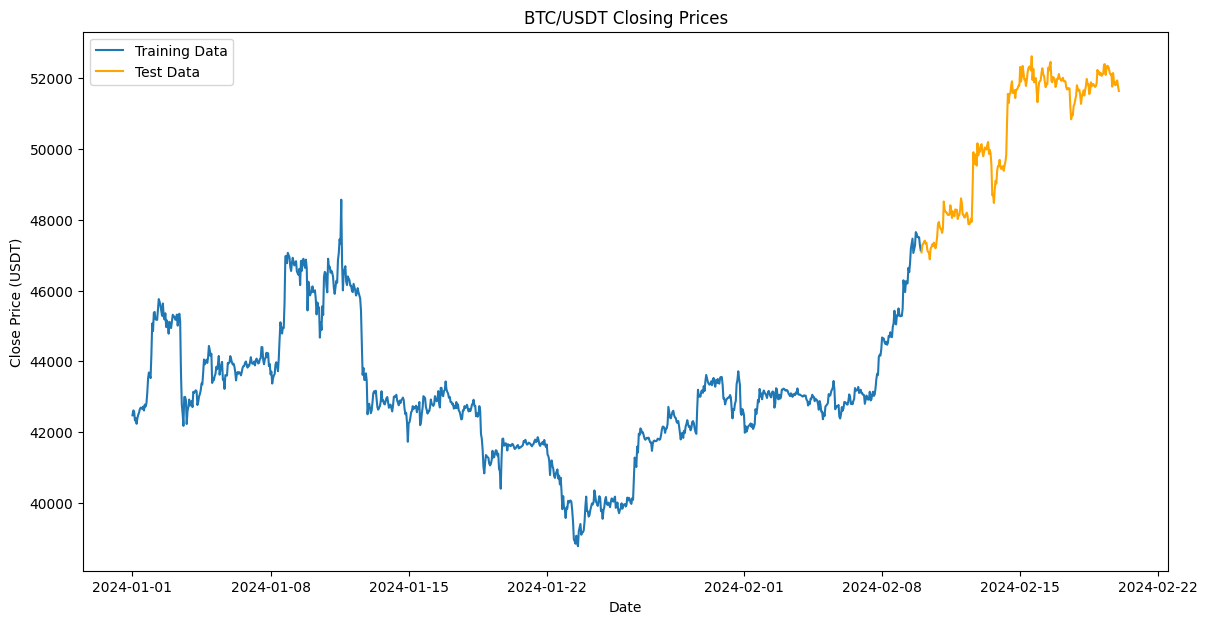

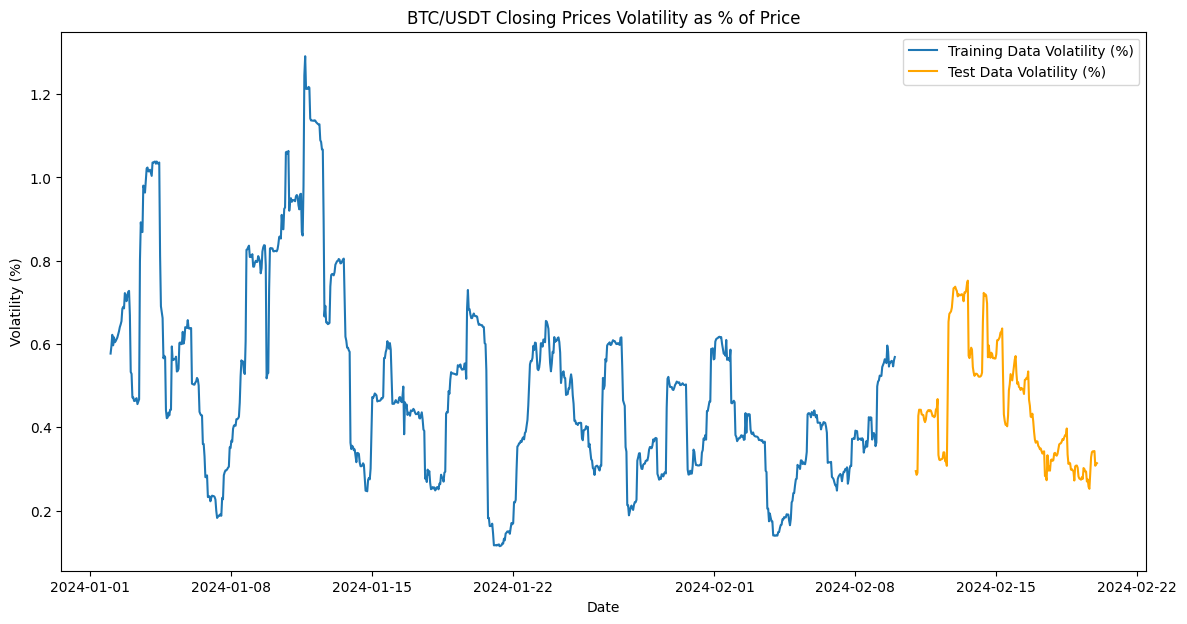

Average Volatility during Train Set for BTC/USDT Closing Prices: 0.49%
Average Volatility during Test Set for BTC/USDT Closing Prices: 0.46%


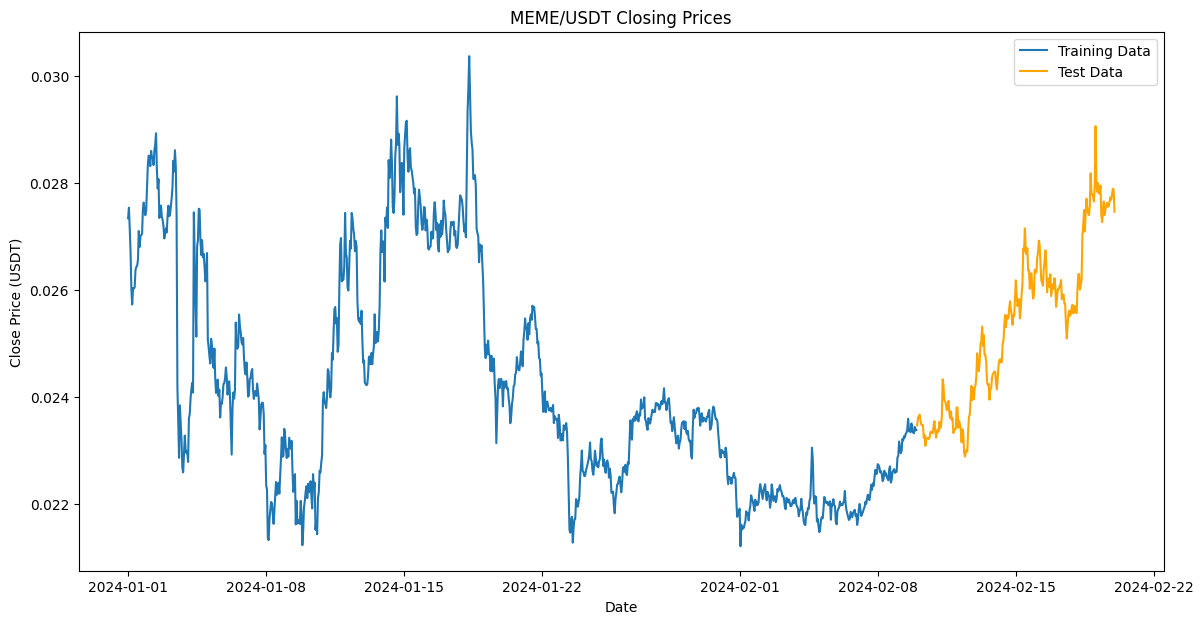

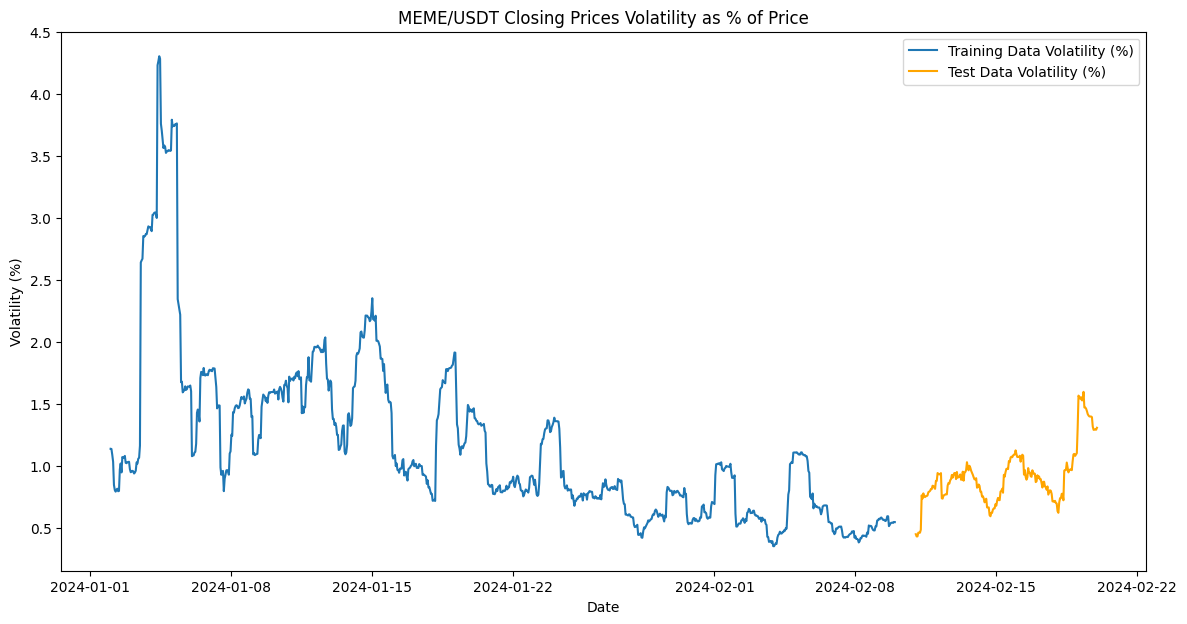

Average Volatility during Train Set for MEME/USDT Closing Prices: 1.16%
Average Volatility during Test Set for MEME/USDT Closing Prices: 0.92%


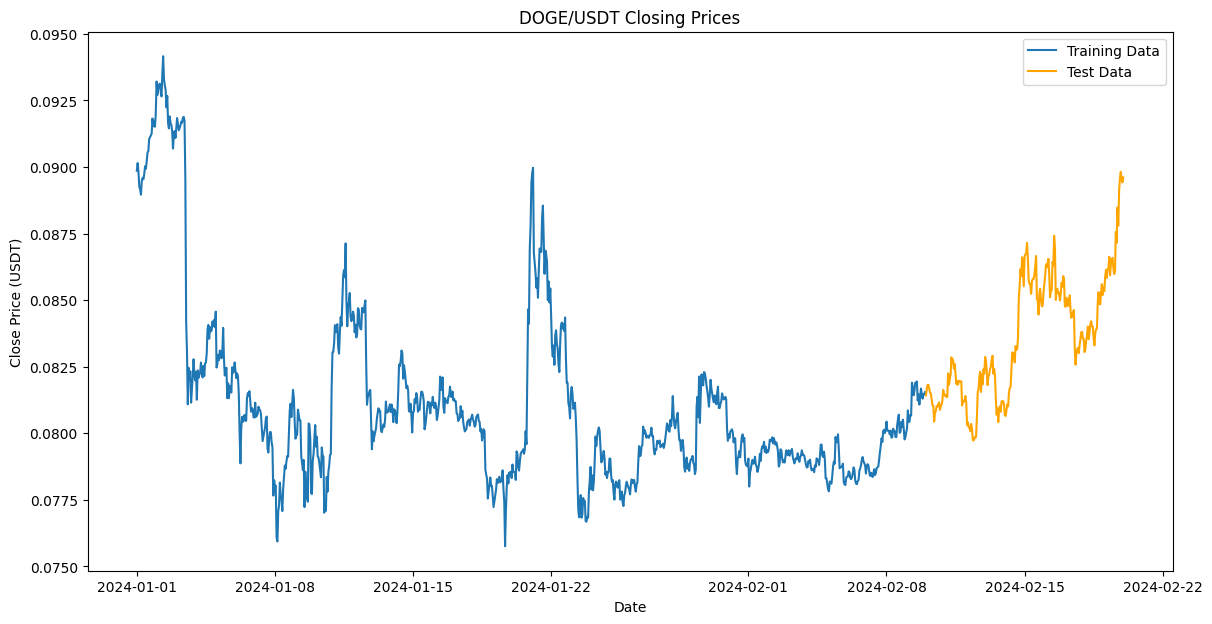

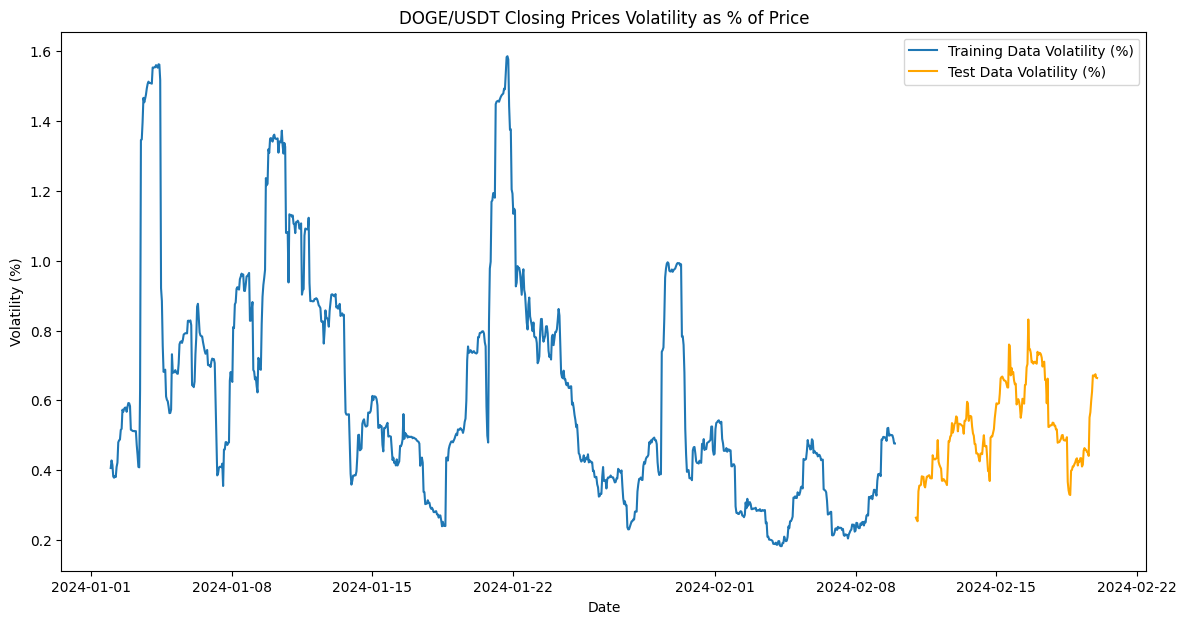

Average Volatility during Train Set for DOGE/USDT Closing Prices: 0.62%
Average Volatility during Test Set for DOGE/USDT Closing Prices: 0.52%


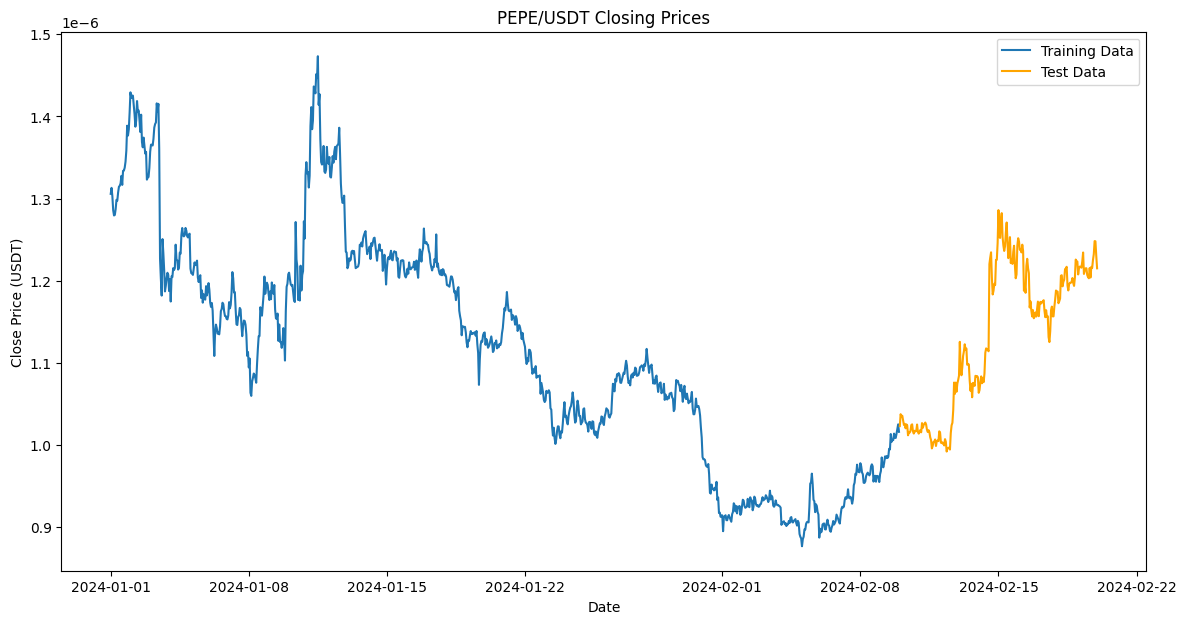

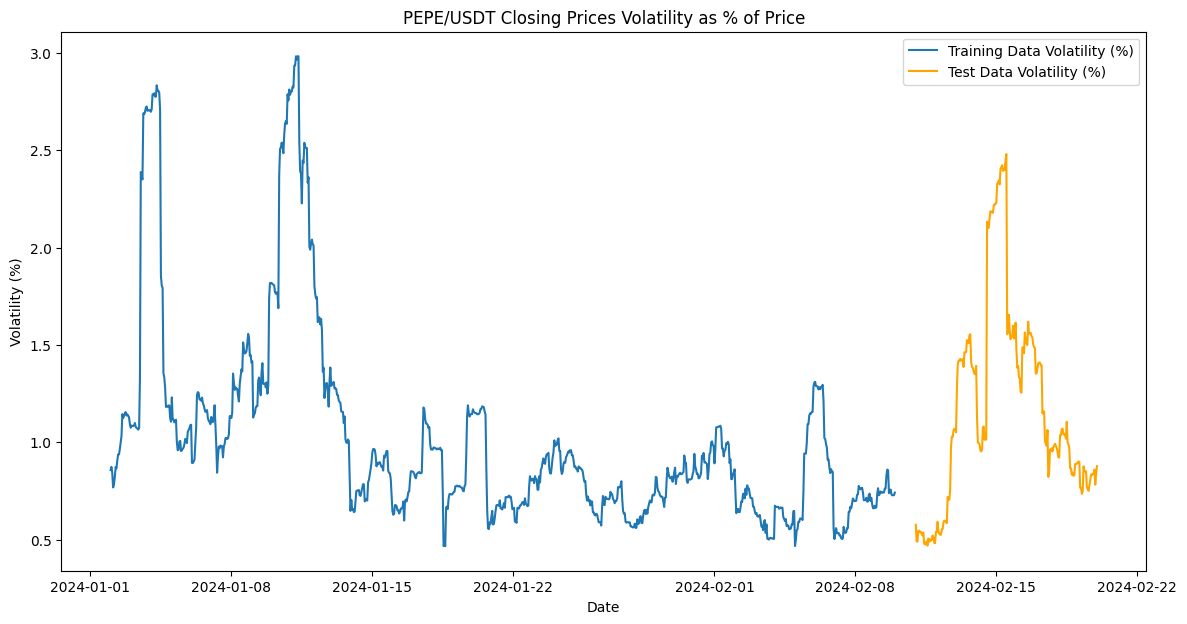

Average Volatility during Train Set for PEPE/USDT Closing Prices: 1.01%
Average Volatility during Test Set for PEPE/USDT Closing Prices: 1.17%


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_closing_prices(training_data, test_data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(training_data['Close'], label='Training Data')
    plt.plot(test_data['Close'], label='Test Data', color='orange')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price (USDT)')
    plt.legend()
    plt.show()

    # Calculate volatility
    training_volatility = training_data['Close'].pct_change().rolling(window=24).std() * 100  # 24-hour (1-day) rolling standard deviation as percentage
    test_volatility = test_data['Close'].pct_change().rolling(window=24).std() * 100

    # Plot volatility as percentage of price
    plt.figure(figsize=(14, 7))
    plt.plot(training_volatility, label='Training Data Volatility (%)')
    plt.plot(test_volatility, label='Test Data Volatility (%)', color='orange')
    
    plt.title(title + ' Volatility as % of Price')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()

    # Calculate average volatility during train and test sets
    avg_training_volatility = np.mean(training_volatility)
    avg_test_volatility = np.mean(test_volatility)
    print(f'Average Volatility during Train Set for {title}: {avg_training_volatility:.2f}%')
    print(f'Average Volatility during Test Set for {title}: {avg_test_volatility:.2f}%')

# Now call the function for each cryptocurrency
plot_closing_prices(btc_training, btc_test, 'BTC/USDT Closing Prices')
plot_closing_prices(meme_training, meme_test, 'MEME/USDT Closing Prices')
plot_closing_prices(doge_training, doge_test, 'DOGE/USDT Closing Prices')
plot_closing_prices(pepe_training, pepe_test, 'PEPE/USDT Closing Prices')


### Reinforcement Learning

 Source: Week 4 Practical Jupyter Notebook on Deep Q Learning was used as a base and modified for the purposes of this task

In [4]:
class DQN_Trader:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()

        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])

        feed = tf.layers.dense(self.X, 512, activation=tf.nn.relu)
        feed = tf.layers.dense(feed, 256, activation=tf.nn.relu)
        feed = tf.layers.batch_normalization(feed)
        feed = tf.layers.dense(feed, 128, activation=tf.nn.relu)

        self.logits = tf.layers.dense(feed, self.action_size)

        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.cost)

        self.sess.run(tf.global_variables_initializer())

        
    def act(self, state):
        # If a random number is less than the exploration rate, select a random action.
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        return np.argmax(self.sess.run(self.logits, feed_dict = {self.X: state})[0])

    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]

        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        
        return np.array([res])

    
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)

        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])

        replay_size = len(mini_batch)

        # Create empty arrays to hold the state and target data
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))

        # Extract the states and next states from the mini batch
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])

        # Obtain Q values for the current and next states
        Q = self.sess.run(self.logits, feed_dict={self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict={self.X: new_states})

        # Loop through the mini batch and update the target Q values
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward

            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])

            X[i] = state
            Y[i] = target

        # Train the neural network on the state and target data
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X: X, self.Y: Y})

        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Return the cost of the neural network during training
        return cost
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            # Initialize variables for the current episode
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money

            # Iterate over the time steps in the trend data
            for t in range(0, len(self.trend) - 1, self.skip):
                # Take an action based on the current state
                action = self.act(state)
                # Get the next state
                next_state = self.get_state(t + 1)

                # If the action is "buy" and there is enough money to buy, add to inventory
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                # If the action is "sell" and there is inventory to sell, sell at current price
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                # Calculate the investment return and add the current step to the replay buffer
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))

                # Update the state for the next step and replay the buffer
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)

            # Print the progress at the checkpoint interval
            if (i+1) % checkpoint == 0:
                print(f'Epoch: {i+1} | Total rewards: {total_profit} | Cost: {cost} | Total money {starting_money}')
       
    def test(self, initial_money, trend):
        # Set the trend data and initial money
        self.trend = trend
        starting_money = initial_money

        # Initialize variables for tracking state and actions
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        pnl_list = []  # List to store PnL for each sale

        # Loop through the trend data and take actions based on the agent's policy
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            # Buy stocks if action is 1 and there is enough money
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                # print(f'Hour {t}: buy 1 unit at price {self.trend[t]}, total balance {initial_money}')

            # Sell stocks if action is 2 and there are stocks in inventory
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                pnl = self.trend[t] - bought_price  # Calculate PnL for this transaction
                pnl_list.append(pnl)  # Append PnL to the list
                # print(f'Hour {t}: sell 1 unit at price {self.trend[t]}, PnL: {pnl}, total balance {initial_money}')

            state = next_state

        # Calculate and return the final results along with the PnL list
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, pnl_list

In [5]:
close_training = btc_training.Close.values.tolist() # Get closing prices.
close_test = btc_test.Close.values.tolist() # Get closing prices.

initial_money = 100000 # Initial amount of money.
window_size = 5 # Lookback window
skip = 1 # Overlap regulator.
batch_size = 64
iterations = 40
checkpoint = 5

# Initialize and train a Trader agent for BTC/USDT
btc_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=btc_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
btc_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=initial_money)


C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:24: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 512, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(feed, 256, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:26: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  feed = tf.layers.batch_normalization(feed)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:27:

Epoch: 5 | Total rewards: 2464.899999999994 | Cost: 0.2814987003803253 | Total money 102464.9
Epoch: 10 | Total rewards: 107.20000000000437 | Cost: 0.11755377054214478 | Total money 100107.19999999998
Epoch: 15 | Total rewards: -479.900000000016 | Cost: 0.018479246646165848 | Total money 99520.09999999999
Epoch: 20 | Total rewards: -501.0000000000218 | Cost: 0.0037105027586221695 | Total money 99499.0
Epoch: 25 | Total rewards: -401.3000000000029 | Cost: 0.0006094481213949621 | Total money 99598.7
Epoch: 30 | Total rewards: -627.6999999999971 | Cost: 6.116784788900986e-05 | Total money 99372.30000000002
Epoch: 35 | Total rewards: 75.80000000000291 | Cost: 7.473965069948463e-06 | Total money 100075.79999999999
Epoch: 40 | Total rewards: -257.5 | Cost: 1.0227813618257642e-05 | Total money 99742.5


In [6]:
# Initialize and train a Trader agent for MEME/USDT
meme_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=meme_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
meme_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=20)

c:\Users\lyakh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\client\session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:24: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 512, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(feed, 256, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:26: UserWarning: `tf.layers

Epoch: 5 | Total rewards: -0.0002480000000000017 | Cost: 1.49506212965278e-10 | Total money 19.999752
Epoch: 10 | Total rewards: 0.0008759999999999983 | Cost: 1.1749534505056669e-11 | Total money 20.000875999999995
Epoch: 15 | Total rewards: -0.00011600000000000152 | Cost: 5.1171740456101844e-14 | Total money 19.999884
Epoch: 20 | Total rewards: -0.0006759999999999995 | Cost: 2.6263203512454612e-14 | Total money 19.999324
Epoch: 25 | Total rewards: -0.00022000000000000144 | Cost: 5.6280982478618125e-12 | Total money 19.999780000000005
Epoch: 30 | Total rewards: 5.600000000000396e-05 | Cost: 2.498731439587367e-14 | Total money 20.000055999999997
Epoch: 35 | Total rewards: -0.00016300000000000342 | Cost: 9.017307774496046e-15 | Total money 19.999837000000007
Epoch: 40 | Total rewards: -0.0005979999999999978 | Cost: 8.804123981232242e-15 | Total money 19.999401999999996


In [7]:
# Initialize and train a Trader agent for DOGE/USDT
doge_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=doge_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
doge_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=50)

C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:24: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 512, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(feed, 256, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:26: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  feed = tf.layers.batch_normalization(feed)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:27:

Epoch: 5 | Total rewards: 0.00039000000000000146 | Cost: 1.3594553927021025e-08 | Total money 50.00039
Epoch: 10 | Total rewards: 0.0001799999999999996 | Cost: 3.0474638112489016e-13 | Total money 50.00018
Epoch: 15 | Total rewards: -0.0012099999999999889 | Cost: 3.8819899443424954e-13 | Total money 49.99879
Epoch: 20 | Total rewards: 0.00034000000000000696 | Cost: 1.2103979152300326e-08 | Total money 50.00034
Epoch: 25 | Total rewards: -0.0011100000000000138 | Cost: 3.3088479872711574e-12 | Total money 49.99889
Epoch: 30 | Total rewards: 0 | Cost: 4.014032555237253e-14 | Total money 50
Epoch: 35 | Total rewards: 0 | Cost: 1.4494899421360619e-13 | Total money 50
Epoch: 40 | Total rewards: -0.0007599999999999829 | Cost: 2.6476100500362476e-13 | Total money 49.99924000000001


In [8]:
# Initialize and train a Trader agent for PEPE/USDT
pepe_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=pepe_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
pepe_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=100)

C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:24: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 512, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(feed, 256, activation=tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:26: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  feed = tf.layers.batch_normalization(feed)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2070202668.py:27:

Epoch: 5 | Total rewards: -1.4689999999999981e-07 | Cost: 1.0695932322896288e-18 | Total money 99.99999985310001
Epoch: 10 | Total rewards: -1.9901000000000036e-06 | Cost: 1.1457498949596356e-08 | Total money 99.9999761930001
Epoch: 15 | Total rewards: -4.576000000000004e-07 | Cost: 1.126605130895592e-19 | Total money 99.99999954240008
Epoch: 20 | Total rewards: -3.410000000000023e-08 | Cost: 7.816349726910617e-18 | Total money 99.99999996590002
Epoch: 25 | Total rewards: -2.7010000000000176e-07 | Cost: 4.669776803840285e-19 | Total money 99.99999972990001
Epoch: 30 | Total rewards: -1.2989999999999864e-07 | Cost: 5.441640617657624e-20 | Total money 99.99999987009998
Epoch: 35 | Total rewards: -1.8269000000000002e-06 | Cost: 1.064494490993852e-18 | Total money 99.99999817310005
Epoch: 40 | Total rewards: 6.559000000000001e-07 | Cost: 6.3594102890868285e-15 | Total money 99.99999964749999


In [96]:
# Run the test method to get the trading results and PnL
def run_test_until_min_trades(agent, initial_money, trend, min_trades=8):
    pnl = []
    while len(pnl) < min_trades:
        _, _, _, _, new_pnl = agent.test(initial_money, trend)
        pnl.extend(new_pnl)  # Assuming new_pnl is a list of PnL values from each trade
    return np.cumsum(pnl)

dqn_btc_cumulative_pnl = run_test_until_min_trades(btc_agent, initial_money, btc_test.Close.values.tolist())
dqn_meme_cumulative_pnl = run_test_until_min_trades(meme_agent, 20, meme_test.Close.values.tolist())
dqn_doge_cumulative_pnl = run_test_until_min_trades(doge_agent, 50, doge_test.Close.values.tolist())
dqn_pepe_cumulative_pnl = run_test_until_min_trades(pepe_agent, 100, pepe_test.Close.values.tolist())


# Print the final cumulative PnL for each token
print(f"Final BTC Cumulative PnL: {dqn_btc_cumulative_pnl[-1]}")
print(f"Final MEME Cumulative PnL: {dqn_meme_cumulative_pnl[-1]}")
print(f"Final DOGE Cumulative PnL: {dqn_doge_cumulative_pnl[-1]}")
print(f"Final PEPE Cumulative PnL: {dqn_pepe_cumulative_pnl[-1]}")


def calculate_sharpe_ratio(pnl_data, risk_free_rate=0.0):
    # Convert PnL to returns
    returns = np.diff(pnl_data) / pnl_data[:-1]
    
    # Calculate the average return and standard deviation of returns
    avg_return = np.mean(returns)
    std_dev = np.std(returns)

    # If the standard deviation is zero, return a Sharpe ratio of 0 to avoid division by zero
    if std_dev == 0:
        return 0

    # Calculate and return the Sharpe ratio
    sharpe_ratio = (avg_return - risk_free_rate) / std_dev
    return sharpe_ratio

# Calculate and print the Sharpe ratio for each token
btc_sharpe_ratio = calculate_sharpe_ratio(dqn_btc_cumulative_pnl)
meme_sharpe_ratio = calculate_sharpe_ratio(dqn_meme_cumulative_pnl)
doge_sharpe_ratio = calculate_sharpe_ratio(dqn_doge_cumulative_pnl)
pepe_sharpe_ratio = calculate_sharpe_ratio(dqn_pepe_cumulative_pnl)

print(f"BTC Sharpe Ratio: {btc_sharpe_ratio}")
print(f"MEME Sharpe Ratio: {meme_sharpe_ratio}")
print(f"DOGE Sharpe Ratio: {doge_sharpe_ratio}")
print(f"PEPE Sharpe Ratio: {pepe_sharpe_ratio}")


Final BTC Cumulative PnL: 1515.4999999999927
Final MEME Cumulative PnL: 0.0014460000000000028
Final DOGE Cumulative PnL: 0.0018900000000000028
Final PEPE Cumulative PnL: 4.411999999999999e-07
BTC Sharpe Ratio: 0.9372306488756507
MEME Sharpe Ratio: 0.8020456256285616
DOGE Sharpe Ratio: 0.690606626569324
PEPE Sharpe Ratio: -0.023992693783149034


In [104]:
def calculate_max_drawdown(pnl_data):
    # Calculate the cumulative returns
    cumulative_returns = np.array(pnl_data)
    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns)
    
    # Calculate the drawdown
    drawdowns = (cumulative_returns - running_max) / running_max
    
    # Calculate the maximum drawdown
    max_drawdown = np.min(drawdowns)
    return max_drawdown

# Calculate and print the maximum drawdown for each token
btc_max_drawdown = calculate_max_drawdown(dqn_btc_cumulative_pnl)
meme_max_drawdown = calculate_max_drawdown(dqn_meme_cumulative_pnl)
doge_max_drawdown = calculate_max_drawdown(dqn_doge_cumulative_pnl)
pepe_max_drawdown = calculate_max_drawdown(dqn_pepe_cumulative_pnl)

print(f"Final BTC Cumulative PnL: {dqn_btc_cumulative_pnl[-1]}")
print(f"Final MEME Cumulative PnL: {dqn_meme_cumulative_pnl[-1]}")
print(f"Final DOGE Cumulative PnL: {dqn_doge_cumulative_pnl[-1]}")
print(f"Final PEPE Cumulative PnL: {dqn_pepe_cumulative_pnl[-1]}")

print(f"BTC Maximum Drawdown: {btc_max_drawdown}")
print(f"MEME Maximum Drawdown: {meme_max_drawdown}")
print(f"DOGE Maximum Drawdown: {doge_max_drawdown}")
print(f"PEPE Maximum Drawdown: {pepe_max_drawdown}")


Final BTC Cumulative PnL: 1515.4999999999927
Final MEME Cumulative PnL: 0.0014460000000000028
Final DOGE Cumulative PnL: 0.0018900000000000028
Final PEPE Cumulative PnL: 4.411999999999999e-07
BTC Maximum Drawdown: 0.0
MEME Maximum Drawdown: -0.15579710144927603
DOGE Maximum Drawdown: -0.8048780487804994
PEPE Maximum Drawdown: -0.3449222323879221


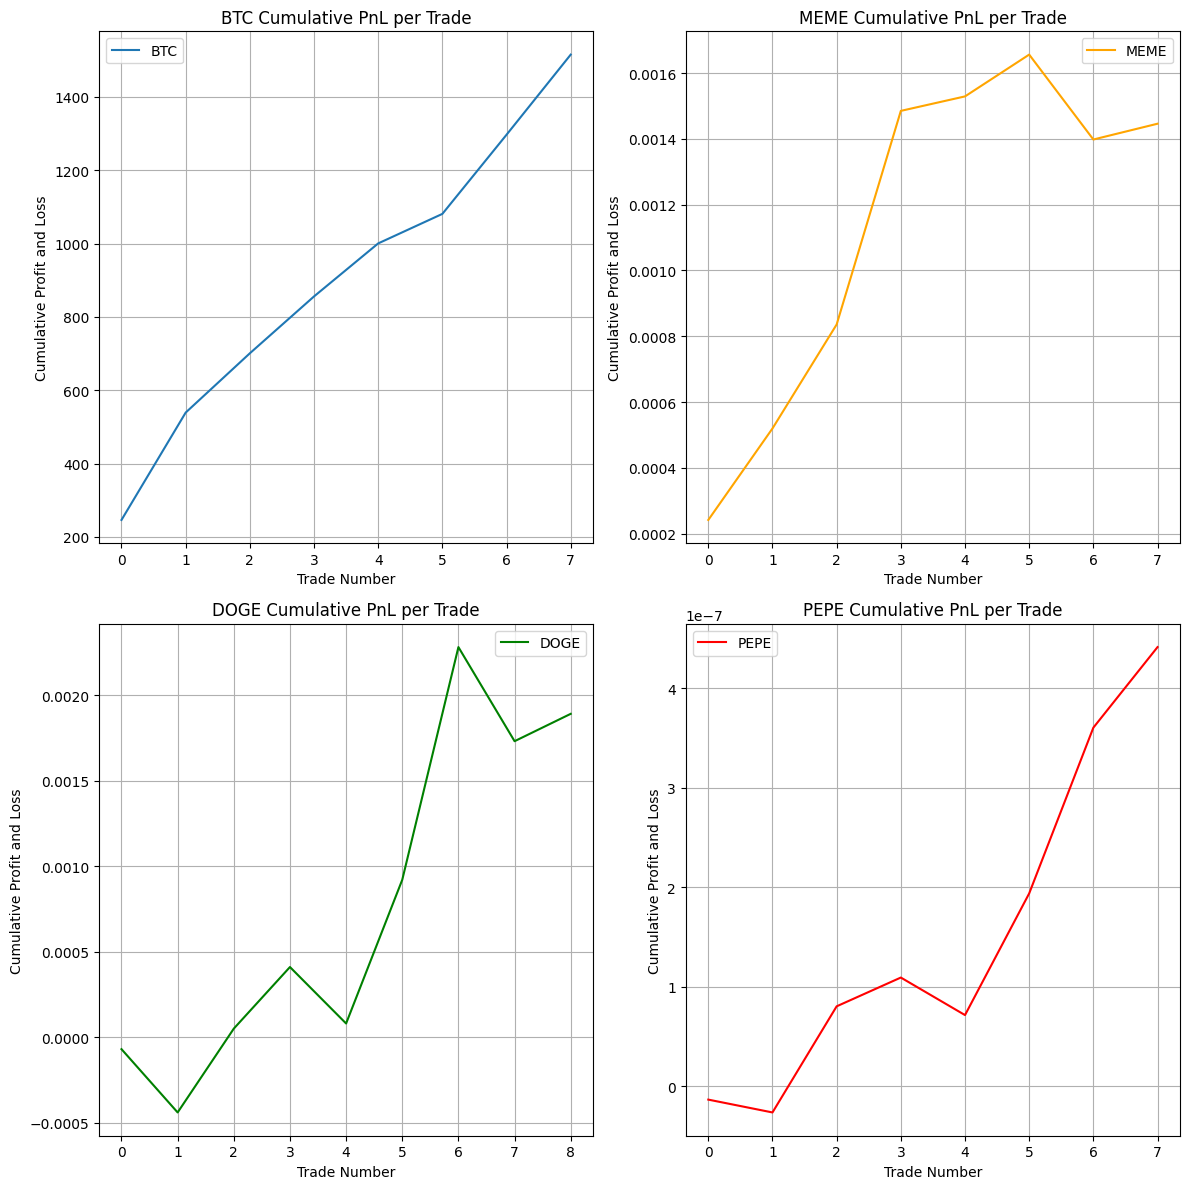

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 plot

# Plot for BTC
axs[0, 0].plot(dqn_btc_cumulative_pnl, label='BTC')
axs[0, 0].set_title('BTC Cumulative PnL per Trade')
axs[0, 0].set_xlabel('Trade Number')
axs[0, 0].set_ylabel('Cumulative Profit and Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot for MEME
axs[0, 1].plot(dqn_meme_cumulative_pnl, label='MEME', color='orange')
axs[0, 1].set_title('MEME Cumulative PnL per Trade')
axs[0, 1].set_xlabel('Trade Number')
axs[0, 1].set_ylabel('Cumulative Profit and Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot for DOGE
axs[1, 0].plot(dqn_doge_cumulative_pnl, label='DOGE', color='green')
axs[1, 0].set_title('DOGE Cumulative PnL per Trade')
axs[1, 0].set_xlabel('Trade Number')
axs[1, 0].set_ylabel('Cumulative Profit and Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot for PEPE
axs[1, 1].plot(dqn_pepe_cumulative_pnl, label='PEPE', color='red')
axs[1, 1].set_title('PEPE Cumulative PnL per Trade')
axs[1, 1].set_xlabel('Trade Number')
axs[1, 1].set_ylabel('Cumulative Profit and Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class QRL_Agent:
    def __init__(self, actions, state_size, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.95, alpha=0.05):
        self.state_size = state_size
        self.action_size = len(actions)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.alpha = alpha
        self.q_table = np.zeros((state_size, self.action_size))
        self.actions = actions

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.actions)
        return np.argmax(self.q_table[state])

    def update_q_table(self, state, action_index, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        td_delta = td_target - self.q_table[state, action_index]
        self.q_table[state, action_index] += self.alpha * td_delta

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class TradingEnvironment:
    def __init__(self, prices):
        self.prices = prices['Close'].values
        self.n = len(self.prices)
        self.current_index = 0
        self.cash = 100000  # Set initial cash to 100,000
        self.holding = False
        self.initial_cash = 100000  # Set initial cash to 100,000
        self.inventory = []  # To store the prices at which units were bought

    def reset(self):
        self.current_index = 0
        self.cash = self.initial_cash
        self.holding = False
        self.inventory = []
        return self._get_state()

    def _get_state(self):
        return 1 if self.holding else 0

    def step(self, action):
        reward = 0
        done = False
        price = self.prices[self.current_index]

        if action == 1 and not self.holding:  # Buy
            self.holding = True
            self.inventory.append(price)
            self.cash -= price
            # print(f'Hour {self.current_index}: buy 1 unit at price {price}, total balance {self.cash}')

        elif action == 2 and self.holding:  # Sell
            self.holding = False
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            self.cash += price
            # print(f'Hour {self.current_index}: sell 1 unit at price {price}, profit {profit}, total balance {self.cash}')
            reward = profit

        self.current_index += 1
        if self.current_index >= self.n:
            done = True

        next_state = self._get_state()
        return next_state, reward, done

def train_agent(epochs, prices):
    env = TradingEnvironment(prices)
    agent = QRL_Agent(actions=[0, 1, 2], state_size=2)
    episode_profits = []  # List to store profits for each episode

    for e in range(epochs):
        state = env.reset()
        total_profit = 0  # Reset total profit for each episode
        step_profits = []  # List to store profits at each step within the episode

        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            
            total_profit += reward
            step_profits.append(total_profit)  # Track profit at each step
            
            state = next_state
            if done:
                episode_profits.append(step_profits)  # Store step profits for the episode
                break

        # print(f"Epoch {e+1}/{epochs}: Total profit: {total_profit}")

    return episode_profits, agent

def test_agent(agent, prices, initial_cash=100000):
    env = TradingEnvironment(prices)
    env.cash = initial_cash
    env.initial_cash = initial_cash
    inventory = []
    state = env.reset()
    pnl_list = []  # List to store PnL for each sale
    states_buy = []
    states_sell = []

    while True:
        action = np.argmax(agent.q_table[state])  # Choose the best action from the Q-table
        next_state, reward, done = env.step(action)

        if action == 1:  # Buy
            inventory.append(env.prices[env.current_index - 1])  # Adjust for index after step
            states_buy.append(env.current_index - 1)
        elif action == 2 and inventory:  # Sell
            bought_price = inventory.pop(0)
            sell_price = env.prices[env.current_index - 1]  # Adjust for index after step
            pnl = sell_price - bought_price
            pnl_list.append(pnl)
            states_sell.append(env.current_index - 1)

        state = next_state
        if done:
            break

    total_profit = sum(pnl_list)
    # print(f"Total profit after testing: {total_profit}")
    return states_buy, states_sell, total_profit, pnl_list


[]
[]
[]
[]


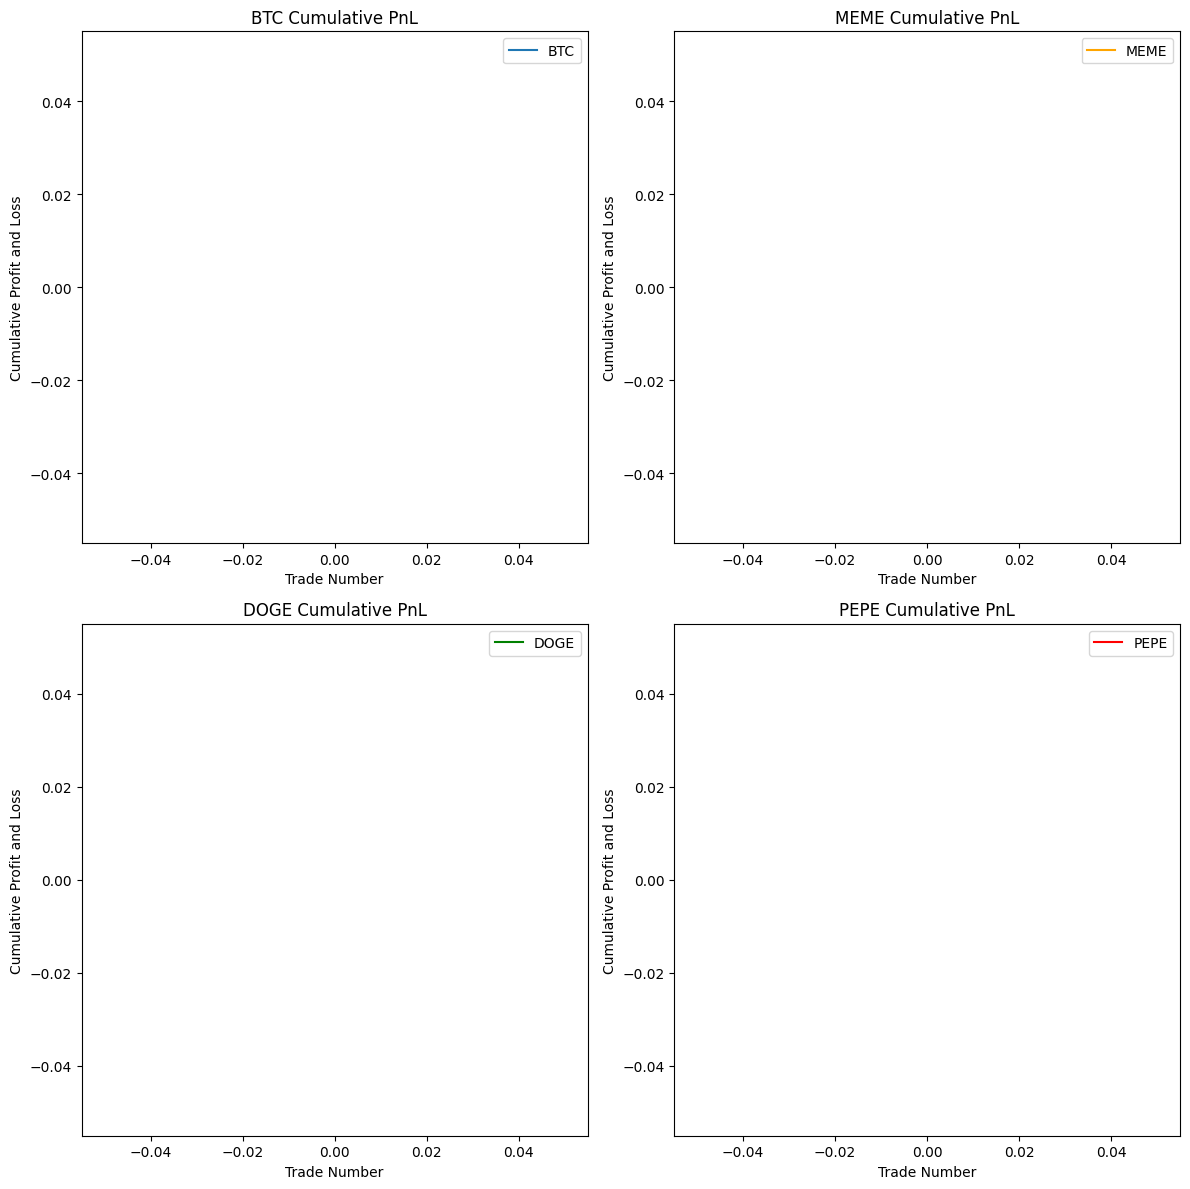

In [11]:
# Train all agents
btc_epoch_profits, Q_btc_agent = train_agent(epochs=200, prices=btc_training)
meme_epoch_profits, Q_meme_agent = train_agent(epochs=200, prices=meme_training)
doge_epoch_profits, Q_doge_agent = train_agent(epochs=200, prices=doge_training)
pepe_epoch_profits, Q_pepe_agent = train_agent(epochs=200, prices=pepe_training)

def test_agent_until_min_pnl(agent, prices, initial_cash=100000, min_pnl_count=1):
    states_buy, states_sell, total_profit, pnl = test_agent(agent, prices, initial_cash)
    while len(pnl) < min_pnl_count:
        additional_states_buy, additional_states_sell, additional_total_profit, additional_pnl = test_agent(agent, prices, initial_cash)
        pnl.extend(additional_pnl)
        # Extend states_buy and states_sell if necessary
        states_buy.extend(additional_states_buy)
        states_sell.extend(additional_states_sell)
    cumulative_pnl = np.cumsum(pnl)
    return states_buy, states_sell, total_profit, cumulative_pnl

# Test the agents until at least 2 PnL values are generated
# btc_states_buy, btc_states_sell, btc_total_profit, btc_cumulative_pnl = test_agent_until_min_pnl(Q_btc_agent, btc_test)
# meme_states_buy, meme_states_sell, meme_total_profit, meme_cumulative_pnl = test_agent_until_min_pnl(Q_meme_agent, meme_test)
# doge_states_buy, doge_states_sell, doge_total_profit, doge_cumulative_pnl = test_agent_until_min_pnl(Q_doge_agent, doge_test)
# pepe_states_buy, pepe_states_sell, pepe_total_profit, pepe_cumulative_pnl = test_agent_until_min_pnl(Q_pepe_agent, pepe_test)

btc_states_buy, btc_states_sell, btc_total_profit, dqn_btc_cumulative_pnl = test_agent(Q_btc_agent, btc_test)
meme_states_buy, meme_states_sell, meme_total_profit, dqn_meme_cumulative_pnl = test_agent(Q_meme_agent, meme_test)
doge_states_buy, doge_states_sell, doge_total_profit, dqn_doge_cumulative_pnl = test_agent(Q_doge_agent, doge_test)
pepe_states_buy, pepe_states_sell, pepe_total_profit, dqn_pepe_cumulative_pnl = test_agent(Q_pepe_agent, pepe_test)

print(dqn_btc_cumulative_pnl)
print(dqn_meme_cumulative_pnl)
print(dqn_doge_cumulative_pnl)
print(dqn_pepe_cumulative_pnl)

# Plotting the cumulative PnL for each token
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].plot(dqn_btc_cumulative_pnl, label='BTC')
axs[0, 0].set_title('BTC Cumulative PnL')
axs[0, 0].set_xlabel('Trade Number')
axs[0, 0].set_ylabel('Cumulative Profit and Loss')
axs[0, 0].legend()

axs[0, 1].plot(dqn_meme_cumulative_pnl, label='MEME', color='orange')
axs[0, 1].set_title('MEME Cumulative PnL')
axs[0, 1].set_xlabel('Trade Number')
axs[0, 1].set_ylabel('Cumulative Profit and Loss')
axs[0, 1].legend()

axs[1, 0].plot(dqn_doge_cumulative_pnl, label='DOGE', color='green')
axs[1, 0].set_title('DOGE Cumulative PnL')
axs[1, 0].set_xlabel('Trade Number')
axs[1, 0].set_ylabel('Cumulative Profit and Loss')
axs[1, 0].legend()

axs[1, 1].plot(dqn_pepe_cumulative_pnl, label='PEPE', color='red')
axs[1, 1].set_title('PEPE Cumulative PnL')
axs[1, 1].set_xlabel('Trade Number')
axs[1, 1].set_ylabel('Cumulative Profit and Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2544661110.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trade_pnl.append(sell_value - (btc_held * data['Close'][i - 1]))  # PnL for this trade
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2544661110.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trade_pnl.append(sell_value - (btc_held * data['Close'][i - 1]))  # PnL for this trade
C:\Users\lyakh\AppData\Local\Temp\ipykernel_1940\2544661110.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

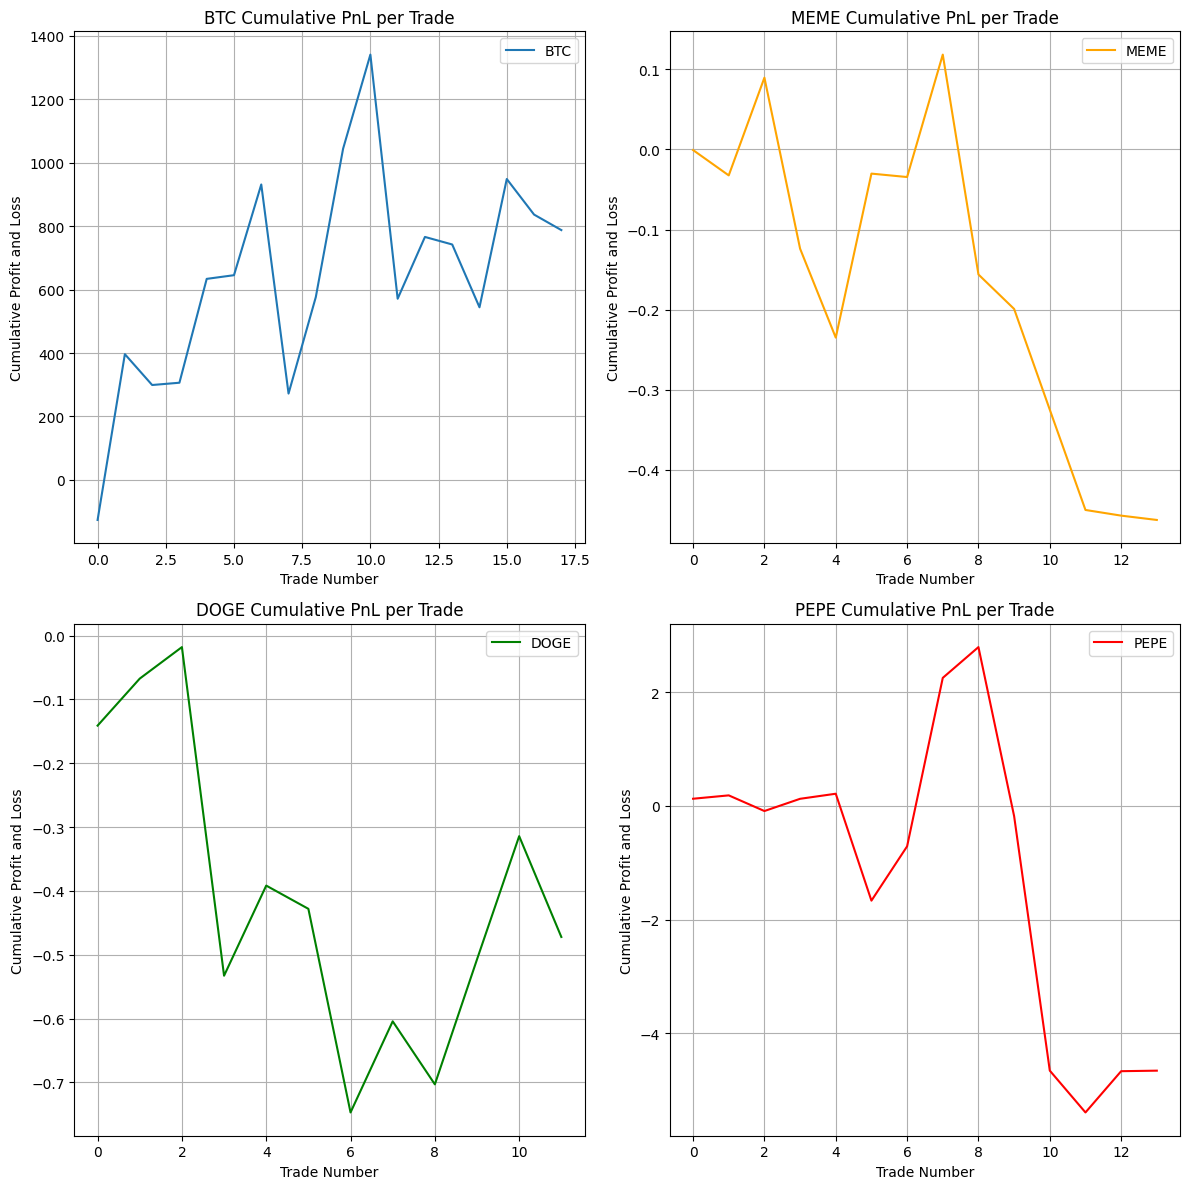

In [98]:
def moving_average_strategy(prices, initial_capital=100000, window_size=10):
    short_window = window_size // 2
    long_window = window_size
    
    data = prices.copy()
    data['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    data['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1).mean()
    data['signal'] = np.where(data['short_mavg'] > data['long_mavg'], 1, 0)
    data['positions'] = data['signal'].diff()

    capital = initial_capital
    btc_held = 0
    trade_pnl = []

    for i, (price, position) in enumerate(zip(data['Close'], data['positions'])):
        if position == 1 and btc_held == 0:  # Buy
            btc_held = capital // price
            capital -= btc_held * price
        elif position == -1 and btc_held > 0:  # Sell
            sell_value = btc_held * price
            trade_pnl.append(sell_value - (btc_held * data['Close'][i - 1]))  # PnL for this trade
            capital += sell_value
            btc_held = 0

    final_value = capital + btc_held * data.iloc[-1]['Close']
    total_profit = final_value - initial_capital

    return np.cumsum(trade_pnl), total_profit  # Return cumulative PnL per trade

# Run the strategy on different datasets
btc_cum_pnl, btc_total_profit = moving_average_strategy(btc_test, initial_capital=100000, window_size=10)
meme_cum_pnl, meme_total_profit = moving_average_strategy(meme_test, initial_capital=20, window_size=10)
doge_cum_pnl, doge_total_profit = moving_average_strategy(doge_test, initial_capital=50, window_size=10)
pepe_cum_pnl, pepe_total_profit = moving_average_strategy(pepe_test, initial_capital=100, window_size=10)

# Plot the cumulative PnL per trade
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].plot(btc_cum_pnl, label='BTC')
axs[0, 0].set_title('BTC Cumulative PnL per Trade')
axs[0, 0].set_xlabel('Trade Number')
axs[0, 0].set_ylabel('Cumulative Profit and Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(meme_cum_pnl, label='MEME', color='orange')
axs[0, 1].set_title('MEME Cumulative PnL per Trade')
axs[0, 1].set_xlabel('Trade Number')
axs[0, 1].set_ylabel('Cumulative Profit and Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(doge_cum_pnl, label='DOGE', color='green')
axs[1, 0].set_title('DOGE Cumulative PnL per Trade')
axs[1, 0].set_xlabel('Trade Number')
axs[1, 0].set_ylabel('Cumulative Profit and Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(pepe_cum_pnl, label='PEPE', color='red')
axs[1, 1].set_title('PEPE Cumulative PnL per Trade')
axs[1, 1].set_xlabel('Trade Number')
axs[1, 1].set_ylabel('Cumulative Profit and Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [103]:

def calculate_max_drawdown(pnl_data):
    # Calculate the cumulative returns
    cumulative_returns = np.array(pnl_data)
    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns)
    
    # Calculate the drawdown
    drawdowns = (cumulative_returns - running_max) / running_max
    
    # Calculate the maximum drawdown
    max_drawdown = np.min(drawdowns)
    return max_drawdown

# Calculate and print the maximum drawdown for each token
btc_max_drawdown = calculate_max_drawdown(btc_cum_pnl)
meme_max_drawdown = calculate_max_drawdown(meme_cum_pnl)
doge_max_drawdown = calculate_max_drawdown(doge_cum_pnl)
pepe_max_drawdown = calculate_max_drawdown(pepe_cum_pnl)

print(f"Final BTC Cumulative PnL: {btc_cum_pnl[-1]}")
print(f"Final MEME Cumulative PnL: {meme_cum_pnl[-1]}")
print(f"Final DOGE Cumulative PnL: {doge_cum_pnl[-1]}")
print(f"Final PEPE Cumulative PnL: {pepe_cum_pnl[-1]}")

print(f"BTC Maximum Drawdown: {btc_max_drawdown}")
print(f"MEME Maximum Drawdown: {meme_max_drawdown}")
print(f"DOGE Maximum Drawdown: {doge_max_drawdown}")
print(f"PEPE Maximum Drawdown: {pepe_max_drawdown}")

def calculate_sharpe_ratio(pnl_data, risk_free_rate=0.0):
    # Convert PnL to returns
    returns = np.diff(pnl_data) / pnl_data[:-1]
    
    # Calculate the average return and standard deviation of returns
    avg_return = np.mean(returns)
    std_dev = np.std(returns)

    # If the standard deviation is zero, return a Sharpe ratio of 0 to avoid division by zero
    if std_dev == 0:
        return 0

    # Calculate and return the Sharpe ratio
    sharpe_ratio = (avg_return - risk_free_rate) / std_dev
    return sharpe_ratio

# Calculate and print the Sharpe ratio for each token
btc_sharpe_ratio = calculate_sharpe_ratio(btc_cum_pnl)
meme_sharpe_ratio = calculate_sharpe_ratio(meme_cum_pnl)
doge_sharpe_ratio = calculate_sharpe_ratio(doge_cum_pnl)
pepe_sharpe_ratio = calculate_sharpe_ratio(pepe_cum_pnl)

print(f"BTC Sharpe Ratio: {btc_sharpe_ratio}")
print(f"MEME Sharpe Ratio: {meme_sharpe_ratio}")
print(f"DOGE Sharpe Ratio: {doge_sharpe_ratio}")
print(f"PEPE Sharpe Ratio: {pepe_sharpe_ratio}")

Final BTC Cumulative PnL: 787.5999999999476
Final MEME Cumulative PnL: -0.4624740000000003
Final DOGE Cumulative PnL: -0.4721600000000379
Final PEPE Cumulative PnL: -4.660423109599947
BTC Maximum Drawdown: -0.7077517715267574
MEME Maximum Drawdown: -4.910059351696731
DOGE Maximum Drawdown: -0.0
PEPE Maximum Drawdown: -8.75458110639754
BTC Sharpe Ratio: -0.0667144549218796
MEME Sharpe Ratio: 0.1925939187455673
DOGE Sharpe Ratio: 0.30536275344797564
PEPE Sharpe Ratio: 0.08193164353333772
